In [130]:
import numpy as np

import matplotlib.pyplot as plt

import scipy.stats.qmc as qmc
import scipy.stats as stats
from scipy.interpolate import interp1d
from scipy.integrate import simps, quad

from tqdm import trange, tqdm
from time import time
from multiprocessing import Pool, cpu_count
from parallelbar import progress_starmap

import src.datamaker as datamaker

import argparse
import os

# set the environment variable to control the number of threads
# NEEDS TO BE DONE BEFORE CCL IS IMPORTED
original_omp_num_threads = os.environ.get('OMP_NUM_THREADS', None)
os.environ['OMP_NUM_THREADS'] = '1'

import pyccl as ccl

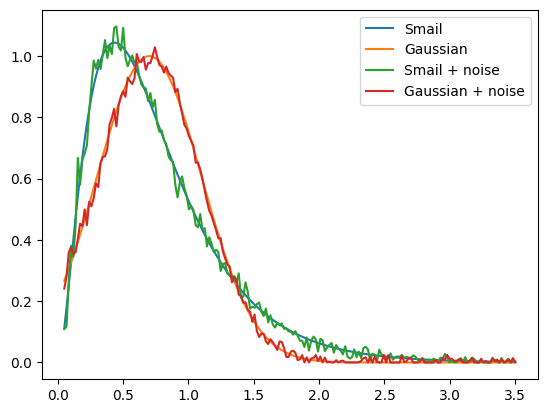

In [131]:
# define various functions to produce redshift distributions
def Smail_dndz(z, z0=0.13, alpha=0.78):
    return z**2 * np.exp(-(z/z0)**alpha)

def Gaussian_dndz(z, z0=0.7, sigma=0.4):
    return np.exp(-0.5 * ((z - z0) / sigma)**2)

def add_noise(z, dndz, noise=0.04):
    # add redshift scaled noise to the dndz
    dndz_noisy = dndz + noise / (1 + z) * np.random.randn(len(dndz))
    dndz_noisy = np.clip(dndz_noisy, 0, None)
    return dndz_noisy

# test the functions
z = np.linspace(0.05, 3.5, 200)
Smail = Smail_dndz(z)
Smail = Smail / simps(Smail, z)

Smail_noisy = add_noise(z, Smail) 
Smail_noisy = Smail_noisy / simps(Smail_noisy, z)

Gaussian = Gaussian_dndz(z)
Gaussian_noisy = add_noise(z, Gaussian)

# plot the results
plt.figure()
plt.plot(z, Smail, label='Smail')
plt.plot(z, Gaussian, label='Gaussian')
plt.plot(z, Smail_noisy, label='Smail + noise')
plt.plot(z, Gaussian_noisy, label='Gaussian + noise')
plt.legend()

In [132]:
# define function to set up redshift bins
def bin_dndz(n_bins, z, dndz_func, **kwargs):

    # Compute the redshift distribution
    dndz = dndz_func(z, **kwargs)

    # Normalize the distribution
    area = simps(dndz, z)  # Integrate dndz_s over z to get the area under the curve
    pdf = dndz / area  # Normalize to make it a PDF

    # Compute the cumulative distribution function (CDF)
    cdf = np.cumsum(pdf) * (z[1] - z[0])  # Approximate the integral to get the CDF

    # Interpolate the CDF to find the bin edges
    inverse_cdf = interp1d(cdf, z, fill_value="extrapolate")

    # Define the CDF values for the bin edges
    cdf_values = np.linspace(0, 1, n_bins+1)

    # Find the corresponding z values (bin edges) for these CDF values
    bin_edges = inverse_cdf(cdf_values)

    z_bin = np.zeros((n_bins, len(z)))
    dndz_bin = np.zeros((n_bins, len(z)))
    for i in range(n_bins):
        z_bin[i] = np.linspace(bin_edges[i], bin_edges[i+1], len(z))
        dndz_bin[i] = dndz_func(z_bin[i], **kwargs)

    return z_bin, dndz_bin 

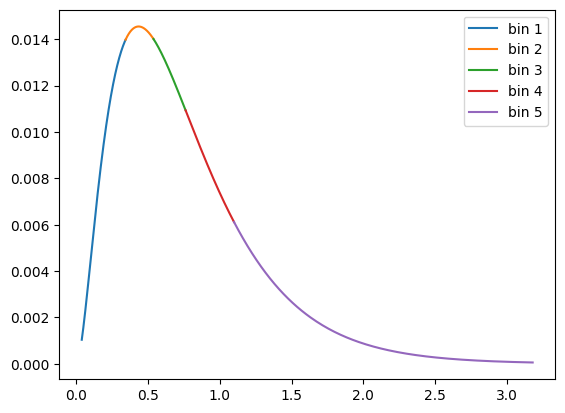

In [133]:
# test the function
n_bins = 5
z_bin, dndz_bin = bin_dndz(n_bins, z, Smail_dndz)

# plot the results
plt.figure()
for i in range(n_bins):
    plt.plot(z_bin[i], dndz_bin[i], label=f'bin {i+1}')
plt.legend()

In [134]:
def convolve_photoz(sigma, zs, dndz_spec, return_2d=False):

     # Convolve with photo-z
    sigma_z = sigma * (1 + zs)

    z_ph = np.linspace(0.1, 4.0, 300)

    # find probability of galaxy with true redshift z_s to be measured at redshift z_ph
    integrand1 = np.zeros([len(zs),len(z_ph)])
    p_zs_zph = np.zeros([len(zs),len(z_ph)])
    for j in range(len(zs)):
        p_zs_zph[j,:] =  (1. / (np.sqrt(2. * np.pi) * sigma_z[j])) * np.exp(-((z_ph - zs[j])**2) / (2. * sigma_z[j]**2))

    integrand1 = p_zs_zph * dndz_spec[:,None]   

    # integrate over z_s to get dN
    integral1 = simps(integrand1, zs, axis=0)
    dN = integral1
    
    dz_ph = simps(dN, z_ph)

    if return_2d:
        return z_ph, dN/dz_ph, p_zs_zph
    
    return z_ph, dN/dz_ph

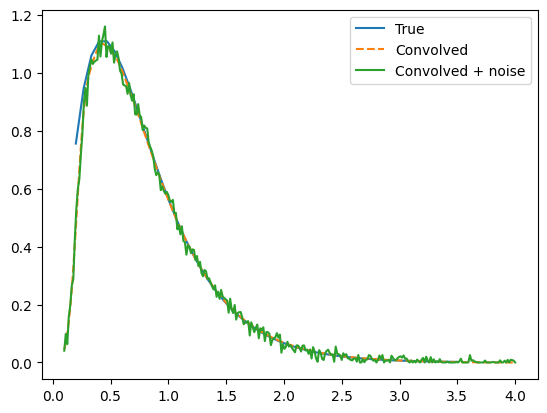

In [135]:
# Single distribution generation procedure
z_spec = np.linspace(0.2, 3.5, 50)

# generate the true distribution
dndz_spec = Smail_dndz(z_spec) / simps(Smail_dndz(z_spec), z_spec)

# convolution with photo-z error
z_ph, dndz_ph = convolve_photoz(0.05, z_spec, dndz_spec)

# add shot noise
dndz_ph_noisy = add_noise(z_ph, dndz_ph, noise=0.04)

# plot the results
plt.figure()
plt.plot(z_spec, dndz_spec, label='True')
plt.plot(z_ph, dndz_ph, label='Convolved', ls='--')
plt.plot(z_ph, dndz_ph_noisy, label='Convolved + noise', ls='-')
plt.legend()

In [136]:
n_tasks = 100
task_distributions = []
for i in range(n_tasks):

    # flip a coin to decide which distribution to use
    model = 'Smail' if np.random.rand() < 0.5 else 'Gaussian'

    # generate the true distribution
    if model == 'Smail':
        z0 = np.random.uniform(0.1, 0.2)
        alpha = np.random.uniform(0.6, 1.0)
        dndz_spec = (
            Smail_dndz(z_spec, z0, alpha)
            / simps(Smail_dndz(z_spec), z_spec)
        )
    else:
        z0 = np.random.uniform(0.2, 1.5)
        sigma = np.random.uniform(0.2, 0.6)
        dndz_spec = (
            Gaussian_dndz(z_spec, z0, sigma) 
            / simps(Gaussian_dndz(z_spec), z_spec)
        )

    # convolution with photo-z error
    z_ph, dndz_ph = convolve_photoz(0.05, z_spec, dndz_spec)

    # flip a coin to decide if we add noise
    noise = True if np.random.rand() < 0.5 else False
    if noise:
        dndz_ph = add_noise(z_ph, dndz_ph, noise=0.04)

    task_distributions.append(dndz_ph)

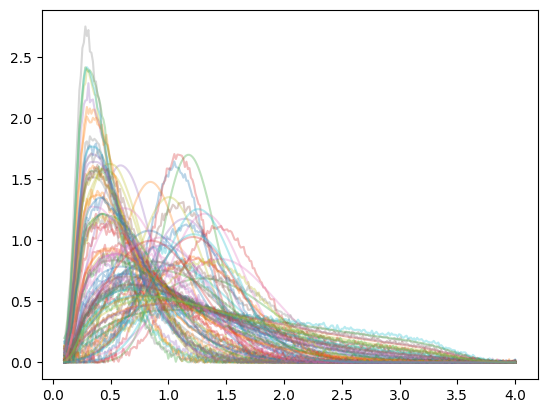

In [137]:
# Plot some of the generated distributions
plt.figure()
for i in range(n_tasks):
    if i % 1 == 0:
        plt.plot(z_ph, task_distributions[i], label=f'Task {i}', alpha=0.3)

In [138]:
n_bins = 5
task_distributions = []
for i in range(n_tasks):
    # First determine model type
    model = 'Smail' if np.random.rand() < 0.5 else 'Gaussian'

    # generate the true distribution
    if model == 'Smail':
        z0 = np.random.uniform(0.1, 0.2)
        alpha = np.random.uniform(0.6, 1.0)
        dndz_spec = (
            Smail_dndz(z_spec, z0, alpha)
            / simps(Smail_dndz(z_spec), z_spec)
        )

        # split the distribution into bins
        z_bin, dndz_bin = bin_dndz(
            n_bins, 
            z_spec, 
            Smail_dndz, 
            z0=z0, 
            alpha=alpha
        )
    else:
        z0 = np.random.uniform(0.2, 1.5)
        sigma = np.random.uniform(0.2, 0.6)
        dndz_spec = (
            Gaussian_dndz(z_spec, z0, sigma) 
            / simps(Gaussian_dndz(z_spec), z_spec)
        )

        # split the distribution into bins
        z_bin, dndz_bin = bin_dndz(
            n_bins, 
            z_spec, 
            Gaussian_dndz, 
            z0=z0, 
            sigma=sigma
        )

    # flip a coin to decide if we add noise
    noise = True if np.random.rand() < 0.5 else False

    # convolution with photo-z error
    dndz_bin_ph = np.zeros((n_bins, len(z_ph)))
    for j in range(n_bins):
        z_ph, dndz_bin_ph[j] = convolve_photoz(
            sigma=0.05,
            zs=z_bin[j],
            dndz_spec=dndz_bin[j]
        )

        if noise:
            dndz_bin_ph[j] = add_noise(z_ph, dndz_bin_ph[j], noise=0.04)

    task_distributions.append(dndz_bin_ph)

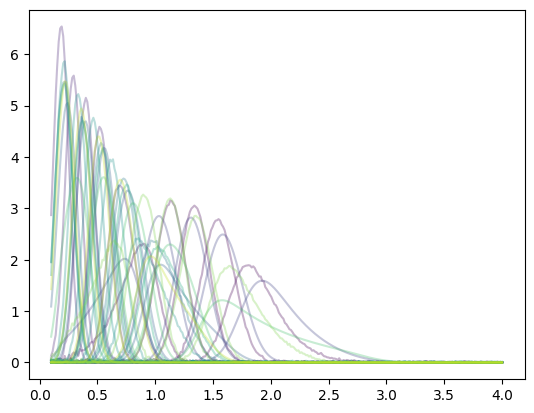

In [139]:
# Plot some of the generated distributions
plt.figure()
color = plt.cm.viridis(np.linspace(0, 1, n_tasks))
for i in range(len(task_distributions)):
    if i % 10 == 0:
        dndz_bin_ph = task_distributions[i]
        for j in range(n_bins):
            plt.plot(z_ph, dndz_bin_ph[j], label=f'Task {i} bin {j}', alpha=0.3,
                     color=color[i])

0.036101849773036675
0.8050924886518338 0.8411943384248703 0.03610184977303654


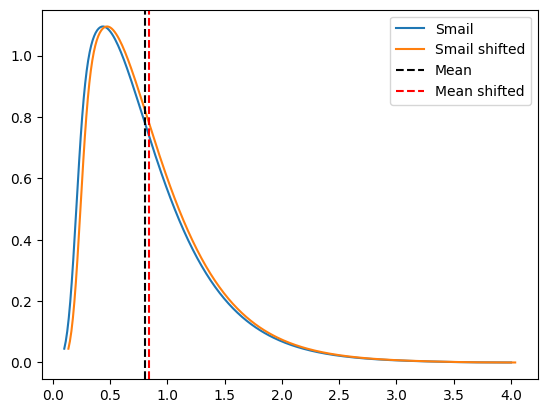

In [140]:
# define function to shift mean of dndz
def shift_mean(z, dndz, delta_z=0.02):
    mean_z = np.average(z, weights=dndz)
    delta_z *= (1 + mean_z)
    print(delta_z)
    z_shift = z + delta_z
    # Clip negative values to zero but ensure each z is
    # unique
    z_shift = np.clip(z_shift, 0, None)
    for i in range(1, len(z_shift)):
        if z_shift[i] == z_shift[i-1]:
            z_shift[i] += 1e-10*i
    return z_shift

# test the function
z = np.linspace(0.2, 3.5, 200)
Smail = Smail_dndz(z)
# Convolve with photo-z
z, Smail = convolve_photoz(0.05, z, Smail)
mean = np.average(z, weights=Smail) # Compute the mean

# Shift the mean
z_shift = shift_mean(z, Smail, delta_z=0.02)
mean_shifted = np.average(z_shift, weights=Smail) # Compute the mean

print(mean, mean_shifted, mean_shifted - mean)

# plot the results
plt.figure()
plt.plot(z, Smail, label='Smail')
plt.plot(z_shift, Smail, label='Smail shifted')
plt.axvline(mean, color='k', ls='--', label='Mean')
plt.axvline(mean_shifted, color='r', ls='--', label='Mean shifted')
plt.legend()

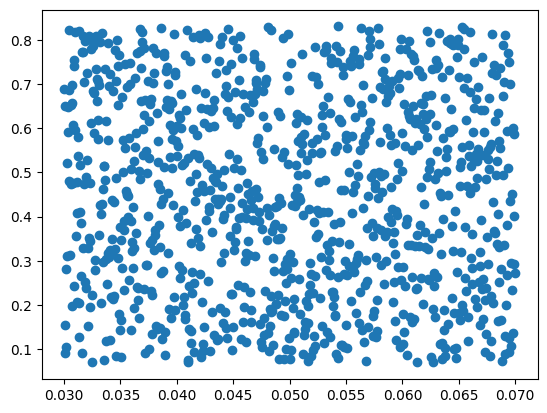

In [141]:
n_samples = 10000

# Construct parameter hypercube from DES Y3 priors
Omega_m = np.array([0.1, 0.9])
Omega_b = np.array([0.03, 0.07])
Omega_c = Omega_m - Omega_b

h = np.array([0.55, 0.91])
n_s = np.array([0.87, 1.07])
sigma8 = np.array([0.6, 0.9])

delta_z = np.array([-0.02, 0.02])# times 5 bins

hyperframe = qmc.LatinHypercube(d=10)
hypercube = hyperframe.random(1000)

# Rescale the hypercube for provided param ranges
l_bounds = [Omega_b[0], Omega_c[0], h[0], sigma8[0], n_s[0],
            delta_z[0], delta_z[0], delta_z[0], delta_z[0], delta_z[0]]
u_bounds = [Omega_b[1], Omega_c[1], h[1], sigma8[1], n_s[1],
            delta_z[1], delta_z[1], delta_z[1], delta_z[1], delta_z[1]]
hypercube = qmc.scale(hypercube, l_bounds, u_bounds)

plt.plot(hypercube[:,0], hypercube[:,1], 'o')

1500
1500


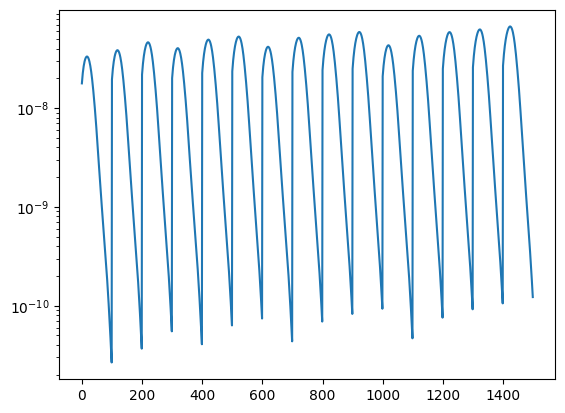

In [142]:
# NEXT STEP IS TO GENERATE THE SPECTRA
def compute_spectra(cosmo, dndz_ph_bins, z_ph, ells):

    n_bins = len(dndz_ph_bins)
    inds = list(zip(*np.tril_indices(n_bins)))

    c_ells = np.empty((len(inds), len(ells)))
    for i, arg in enumerate(inds):
        j, k = arg
        tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z_ph, dndz_ph_bins[j]))
        tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z_ph, dndz_ph_bins[k]))
        c_ells[i,:] = ccl.angular_cl(cosmo, tracer1, tracer2, ells)
    
    return c_ells.flatten()

# test function

# Define the cosmology
cosmo = ccl.Cosmology(
    Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96
)

dndz_ph_bins = task_distributions[0]
z_ph = z_ph

ells = np.geomspace(2, 5000, 100)

inds = list(zip(*np.tril_indices(n_bins)))

print(len(ells)*len(inds))

c_ells = compute_spectra(cosmo, dndz_ph_bins, z_ph, ells)
print(len(c_ells))
plt.figure()
plt.plot(c_ells)
plt.yscale('log')

In [143]:
def compute_spectra(theta, dndz_ph_bins, z_ph, ells):
    '''
    Compute the angular power spectra for the given redshift distributions.
    Args:
    theta: cosmological parameters (array-like)
    dndz_ph_bins: redshift distributions (list of array-like)
    z_ph: redshift (array-like)
    ells: multipoles (array-like)
    shift_mean: shift in the mean redshift of the distribution (float)'''

    cosmo = ccl.Cosmology(
        Omega_c=theta[0],
        Omega_b=theta[1],
        h=theta[2],
        sigma8=theta[3],
        n_s=theta[4],
        matter_power_spectrum='halofit'
    )

    n_bins = len(dndz_ph_bins)
    inds = list(zip(*np.tril_indices(n_bins)))

    z_ph_shifted = np.empty((n_bins, len(z_ph)))
    for i in range(n_bins):
        z_ph_shifted[i] = shift_mean(
            z_ph, 
            dndz_ph_bins[i],
            delta_z=theta[5+i]
        )

    c_ells = np.empty((len(inds), len(ells)))
    print(inds)
    for i, arg in enumerate(inds):
        j, k = arg
        print(j,k)
        tracer1 = ccl.WeakLensingTracer(
            cosmo,
            dndz=(z_ph_shifted[j], dndz_ph_bins[j])
        )
        tracer2 = ccl.WeakLensingTracer(
            cosmo,
            dndz=(z_ph_shifted[k], dndz_ph_bins[k])
        )
        c_ells[i,:] = ccl.angular_cl(cosmo, tracer1, tracer2, ells)
    
    return c_ells.flatten()